### 1. L2-MLR regression of gcPBM dataset of Max, Myc and Mad TFs

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.model_selection import cross_val_score,cross_val_predict
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

### 2. Function to read the files with features and nested cross-validation

In [3]:
import os
import pandas as pd
import numpy as np

def encode_gcPBM_data(fileprefix, 
                      data_dir="/SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers", 
                features=("1mer",), w=0):
    
    try:
        # Load 1mer data
        ohe_file = os.path.join(data_dir, "1mer", f"{fileprefix}_1mer.tsv")
        ohe_df = pd.read_csv(ohe_file, header=None, sep="\t")
        
        ohe_data = {row[0]: {'aff': float(row[0].split('__')[1]), 
                             'feat': row.iloc[1:].tolist()} for _, row in ohe_df.iterrows()}
        
        print(f"1mer data loaded from {ohe_file}... \n")
    
    except FileNotFoundError as fe:
        raise FileNotFoundError(f"File {ohe_file} not found: {fe}")

    combined_data = ohe_data.copy()

    # Load additional features if specified
    if len(features) > 1:
        for feature in features[1:]:
            print(f"Will load the additional feature {feature}")
            try:
                flex_feat_file = os.path.join(data_dir, "FLEX", f"{fileprefix}_w{w}nt_{feature}.tsv")
                flex_df = pd.read_csv(flex_feat_file, sep="\t", header=None)

                for ids in ohe_data.keys():
                    flex_df_row = flex_df[flex_df[0] == ids]
                    if not flex_df_row.empty:
                        flex_df_feat = np.array(flex_df_row.iloc[0, 1:].tolist()) # first column is id

                        # Scale the flex features
                        min_value = np.min(flex_df_feat)
                        std_value = np.std(flex_df_feat)
                        if std_value != 0:
                            scaled_flex_feat = (flex_df_feat - min_value) / std_value
                        else:
                            scaled_flex_feat = flex_df_feat  # If std is 0, scaling is not possible

                        # Calculate interaction terms for this feature using NumPy
                        interaction_terms = scaled_flex_feat[:-1] * scaled_flex_feat[1:]

                        combined_data[ids]['feat'].extend(scaled_flex_feat.tolist() + interaction_terms.tolist())
                print(f"{feature} data loaded from {flex_feat_file}... \n")
            except FileNotFoundError as fe:
                raise FileNotFoundError(f"File {flex_feat_file} not found: {fe}")
            except Exception as e:
                raise Exception(f"Error in extending feature {feature} from {flex_feat_file}: {e}")

    # Define X, y
    X = np.array([combined_data[x]['feat'] for x in combined_data.keys()])
    y = np.array([combined_data[x]['aff'] for x in combined_data.keys()])
#     y_scaler = MinMaxScaler()
#     y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()


    return X, y


In [33]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from scipy.stats import spearmanr, rankdata
import matplotlib.pyplot as plt

def nested_ridge_cv(X, y, fileid, pos, features, outer_cv_folds=10, inner_cv_folds=5):
    alphas = np.linspace(1, 100, 1000)
    
    outer_cv = KFold(n_splits=outer_cv_folds, shuffle=True, random_state=42)
    outer_results = []

    for train_idx, test_idx in outer_cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        inner_cv = KFold(n_splits=inner_cv_folds, shuffle=True, random_state=42)
        ridge_cv_model = make_pipeline(StandardScaler(with_mean=False),
                                       RidgeCV(alphas=alphas, cv=inner_cv, scoring='r2'))
        
        ridge_cv_model.fit(X_train, y_train)
        best_alpha = ridge_cv_model.named_steps['ridgecv'].alpha_
        
        y_test_pred = ridge_cv_model.predict(X_test)
        r2_test = r2_score(y_test, y_test_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
        
        # Calculate Spearman rank correlation
        spearman_corr, _ = spearmanr(y_test, y_test_pred)
        
        result = {
            'fileid': fileid,
            'pos': pos,
            'features': features,
            'r2_test': r2_test,
            'mse_test': mse_test,
            'mae_test': mae_test,
            'best_alpha': best_alpha,
            'spearman_corr': spearman_corr
        }
        outer_results.append(result)
    
    # Calculate the mean best alpha from outer results
    best_alpha = np.mean([res['best_alpha'] for res in outer_results])
    
    # Train the final model on the entire dataset with the best alpha
    final_model = make_pipeline(StandardScaler(with_mean=False),
                                RidgeCV(alphas=[best_alpha], cv=inner_cv, scoring='r2'))
    final_model.fit(X, y)
    
    # Make final predictions
    final_predictions = final_model.predict(X)
    
    # Calculate Spearman rank correlation on the entire dataset
    spearman_corr_final, _ = spearmanr(y, final_predictions)
    print(f"Final Spearman rank correlation on the entire dataset: {spearman_corr_final}")
    
    # Calculate R² value for final predictions
    r2_final = r2_score(y, final_predictions)
    print(f"Final R² value on the entire dataset: {r2_final}")
    
    # Plot actual vs. predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y, final_predictions, alpha=0.5, label='Data points')
    
    # Add line of best fit
    m, b = np.polyfit(y, final_predictions, 1)
    plt.plot(y, m*y + b, color='red', label=f'Line of best fit (R² = {r2_final:.2f})')
    
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs. Predicted Values')
    plt.legend()
    plt.show()
    
    # Plot ranks of actual vs. predicted values
    actual_ranks = rankdata(y, method='average')
    predicted_ranks = rankdata(final_predictions, method='average')
    
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_ranks, predicted_ranks, alpha=0.5, label='Data points')
    
    # Add line of best fit for ranks
    m_ranks, b_ranks = np.polyfit(actual_ranks, predicted_ranks, 1)
    plt.plot(actual_ranks, m_ranks*actual_ranks + b_ranks, color='red', label=f'Line of best fit (R² = {r2_final:.2f})')
    
    plt.xlabel('Actual Ranks')
    plt.ylabel('Predicted Ranks')
    plt.title('Ranks of Actual vs. Predicted Values')
    plt.legend()
    plt.show()
    
    # Return results, actual and predicted data
    return outer_results, y, final_predictions

# Example usage:
# X_new, y_new = encode_selex_data(fileprefix="MAX_10mer", features=fset)
# res, actual_data, predicted_data = nested_ridge_cv(X=X_new, y=y_new, fileid=record, pos="all", features=fset, outer_cv_folds=10, inner_cv_folds=5)

# You can now use the `actual_data` and `predicted_data` as needed

In [34]:
from itertools import product


ohe = ["1mer"]

features = [('1mer', ), ('1mer', "DNaseI", 'twistDisp', 'NPP', 'stiffness', 'trxDi')]
results_df_f_combined = []

features

[('1mer',), ('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi')]

### 3. Run the models

In [35]:
gcPBM_trimmed_result = []

Running for file: Max 

current feature is: ('1mer',)...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Max_1mer.tsv... 

Final Spearman rank correlation on the entire dataset: 0.9094393974574797
Final R² value on the entire dataset: 0.8155291433469063


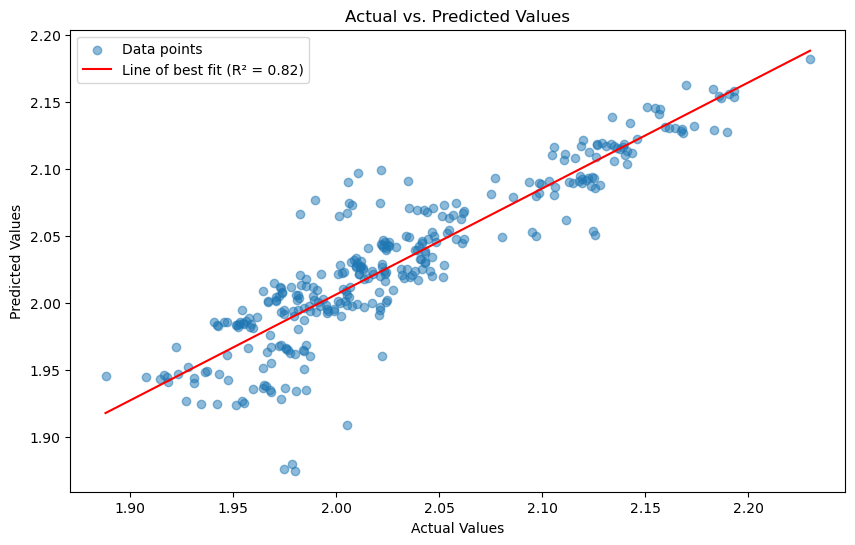

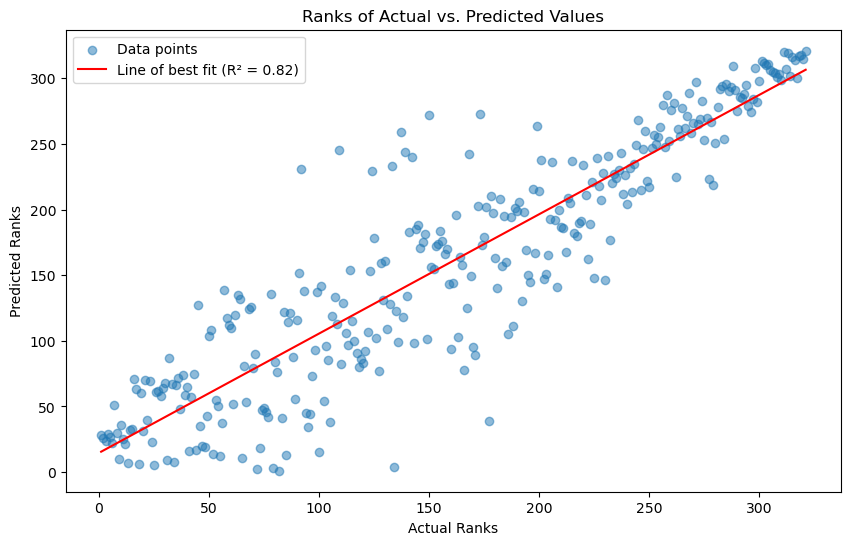

current feature is: ('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi')...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Max_1mer.tsv... 

Will load the additional feature DNaseI
DNaseI data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Max_w0nt_DNaseI.tsv... 

Will load the additional feature twistDisp
twistDisp data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Max_w0nt_twistDisp.tsv... 

Will load the additional feature NPP
NPP data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Max_w0nt_NPP.tsv... 

Will load the additional feature stiffness
stiffness data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Max_w0nt_stiffness.tsv... 

Will load the additional feature trxDi
trxDi data loaded from /SynologyNAS/001_T

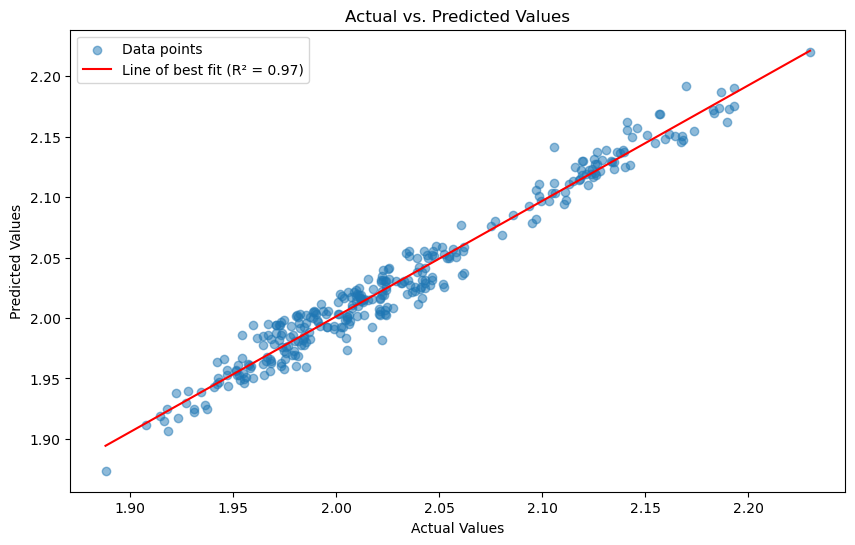

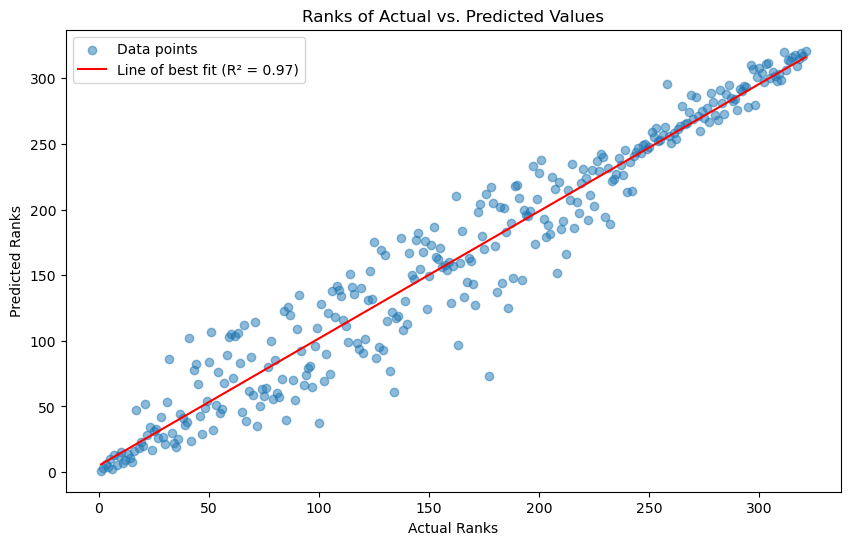

Running for file: Myc 

current feature is: ('1mer',)...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Myc_1mer.tsv... 

Final Spearman rank correlation on the entire dataset: 0.9269326593550646
Final R² value on the entire dataset: 0.8674726120216585


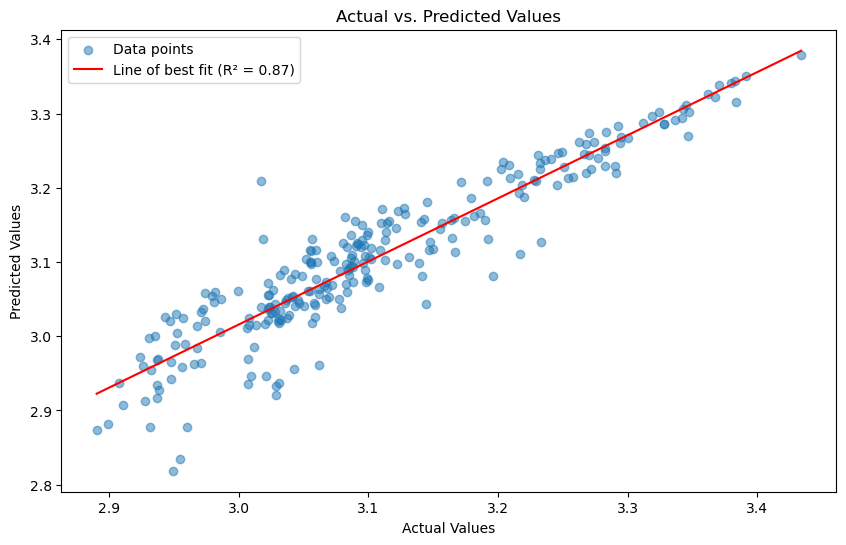

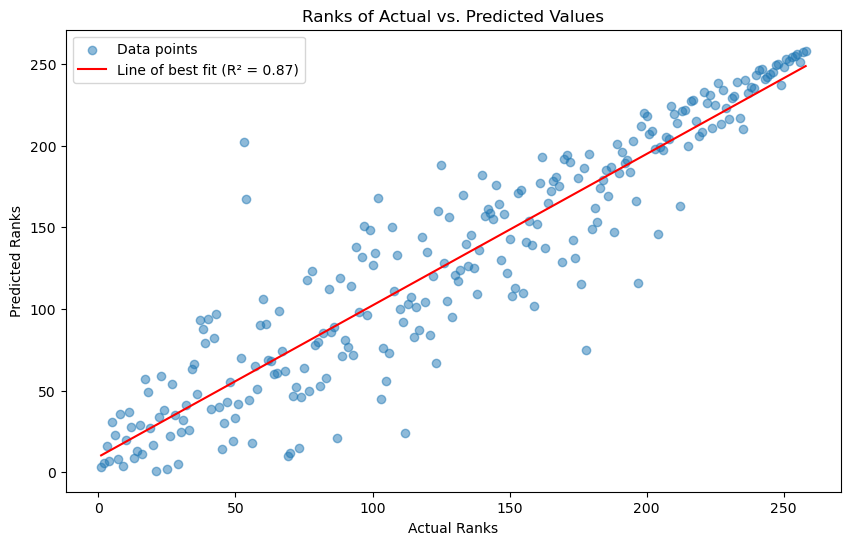

current feature is: ('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi')...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Myc_1mer.tsv... 

Will load the additional feature DNaseI
DNaseI data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Myc_w0nt_DNaseI.tsv... 

Will load the additional feature twistDisp
twistDisp data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Myc_w0nt_twistDisp.tsv... 

Will load the additional feature NPP
NPP data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Myc_w0nt_NPP.tsv... 

Will load the additional feature stiffness
stiffness data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Myc_w0nt_stiffness.tsv... 

Will load the additional feature trxDi
trxDi data loaded from /SynologyNAS/001_T

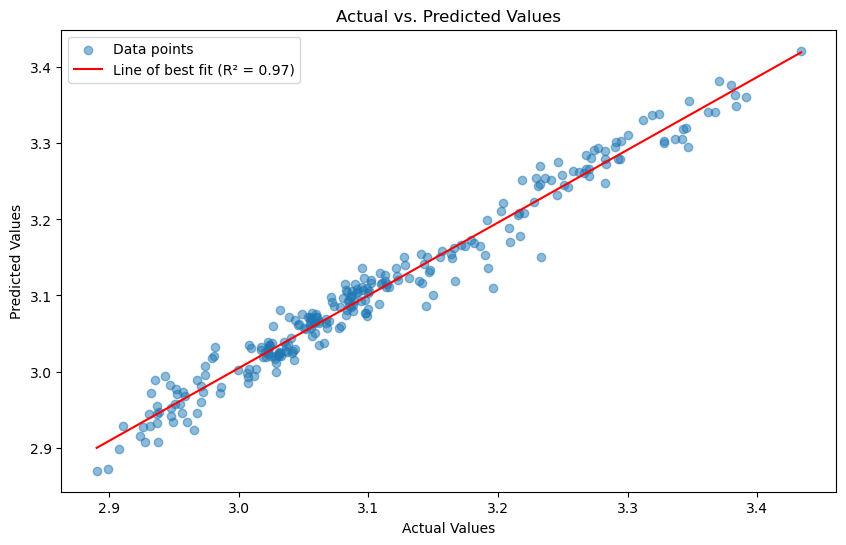

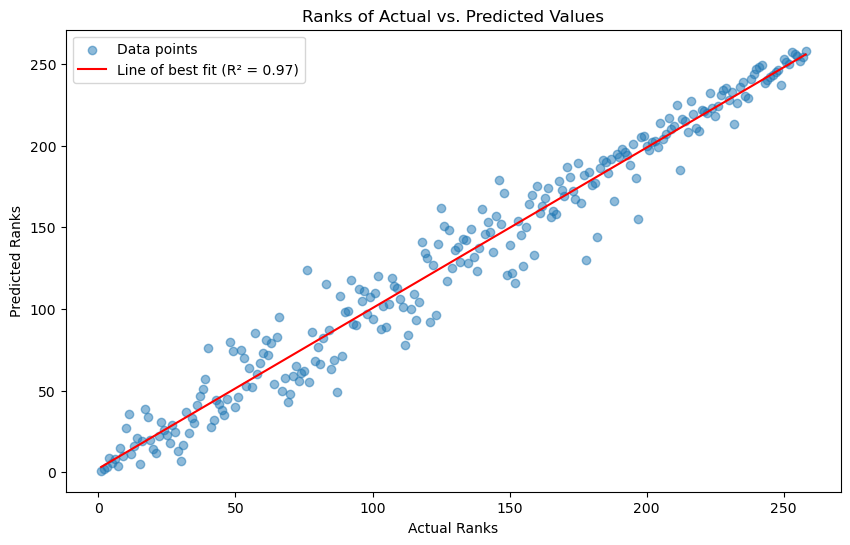

Running for file: Mad 

current feature is: ('1mer',)...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Mad_1mer.tsv... 

Final Spearman rank correlation on the entire dataset: 0.9271046242060933
Final R² value on the entire dataset: 0.8337373340524348


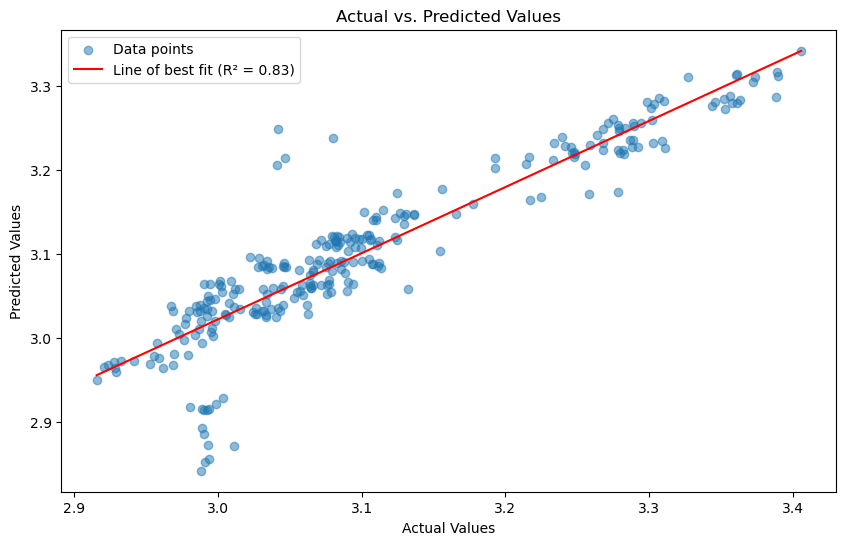

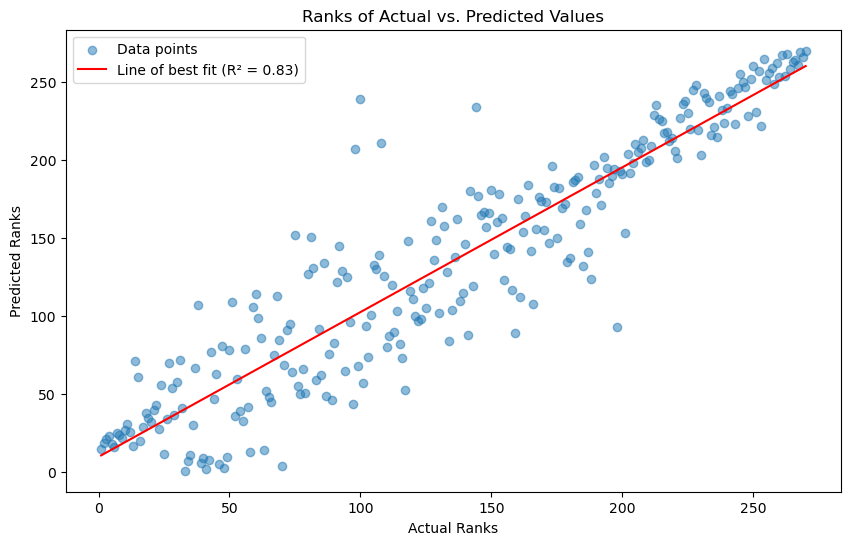

current feature is: ('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi')...

1mer data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/1mer/Mad_1mer.tsv... 

Will load the additional feature DNaseI
DNaseI data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Mad_w0nt_DNaseI.tsv... 

Will load the additional feature twistDisp
twistDisp data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Mad_w0nt_twistDisp.tsv... 

Will load the additional feature NPP
NPP data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Mad_w0nt_NPP.tsv... 

Will load the additional feature stiffness
stiffness data loaded from /SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/FLEX/Mad_w0nt_stiffness.tsv... 

Will load the additional feature trxDi
trxDi data loaded from /SynologyNAS/001_T

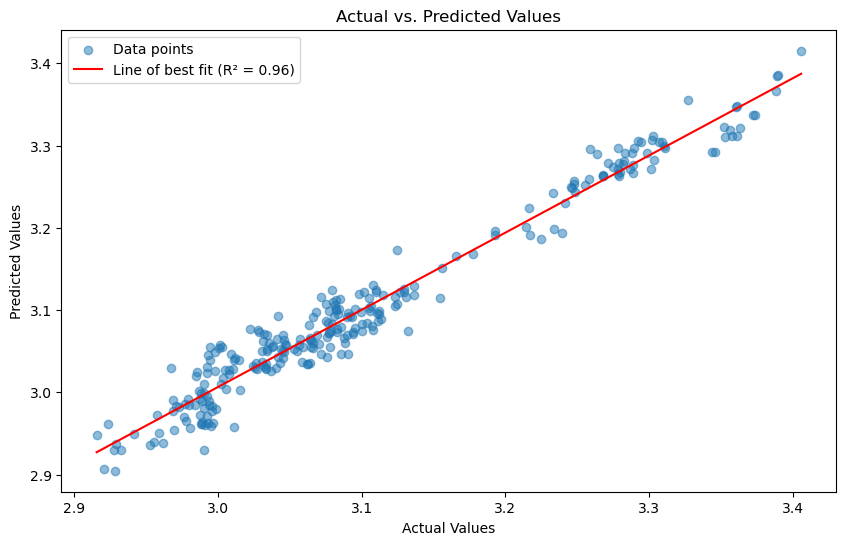

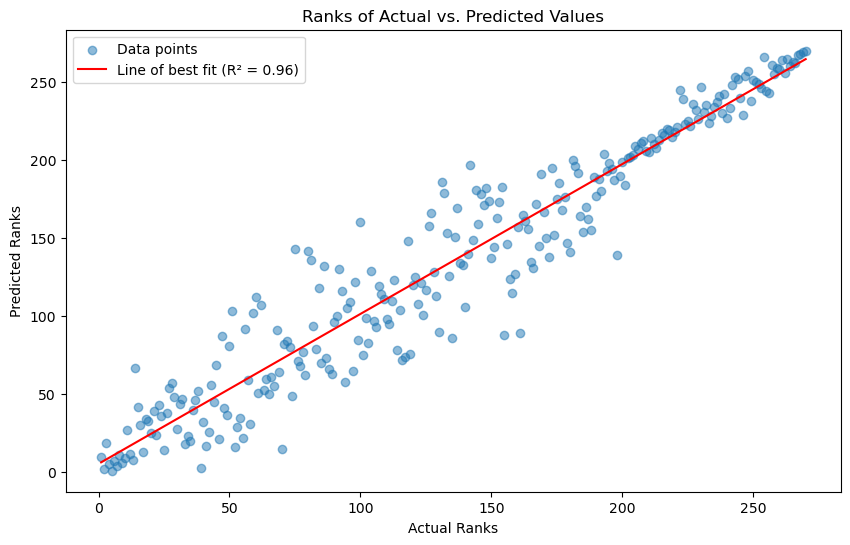

In [36]:

for record in ['Max', 'Myc', 'Mad']:
    
    print(f"Running for file: {record} \n")
    
    for fset in features:
        print(f"current feature is: {fset}...\n")
        X, y = encode_gcPBM_data(fileprefix=record, features=fset)
        
#         # Split data into training (80%) and testing (20%) sets
#         X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
        
        # Perform nested cross-validation
        res,actual,predicted = nested_ridge_cv(X=X, 
                              y=y, 
                              fileid=record, 
                              pos="all", 
                              features=fset, 
                              outer_cv_folds=10, 
                              inner_cv_folds=5)
        gcPBM_trimmed_result.append([res, actual, predicted])

### Save the L2-MLR results

In [50]:
gcpbm_l2_mlr = []

for i in gcPBM_trimmed_result:
    for j in i[0]:
        gcpbm_l2_mlr.append(j)

In [53]:
pd.DataFrame(gcpbm_l2_mlr).to_csv("/SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/RESULTS/gcPBM_10mers_L2_MLR.tsv",
                                 sep="\t", index=False)

In [73]:
results_dir = "/SynologyNAS/001_Thesis_work/Prj_TF_FAMILY_SPECIFIC/RESULTS/gcPBM_trimmed_10mers/RESULTS"

#### Save the actual and predicted values

In [82]:
for i in gcPBM_trimmed_result:
#     for j in i[0]:
#     print(f"TF: {i[0][0]['fileid']}\nFeature:{i[0][0]['features']} \nactual: {i[1]}\n, predicted: {i[2]}")
    TF = f"{i[0][0]['fileid']}"
    Feature = f"{i[0][0]['features']}"
    f = "1mer_Flex" if 'DNaseI' in Feature else "1mer"

    print(Feature, TF, f)
#     print(f"actual: {i[1]}\n, predicted: {i[2]}")
    d = pd.DataFrame({"actual": i[1],
                  "predicted": i[2],
                  "model": f,
                      "tf": TF
                 })
    d.to_csv(f"{results_dir}/{TF}_{f}_actual_and_predicted.tsv", sep="\t", index=False)
    

('1mer',) Max 1mer
('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi') Max 1mer_Flex
('1mer',) Myc 1mer
('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi') Myc 1mer_Flex
('1mer',) Mad 1mer
('1mer', 'DNaseI', 'twistDisp', 'NPP', 'stiffness', 'trxDi') Mad 1mer_Flex
